In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import collections

# Importing Processed Data

In [2]:
dfTrain = pd.read_csv('trainData.csv')                   # train dataframe
dfTest = pd.read_csv('testData.csv')                     # test dataframe
dfTrain.head()

,pixle 1,pixle 2,pixle 3,pixle 4,pixle 5,pixle 6,pixle 7,pixle 8,pixle 9,pixle 10,...,pixle 55,pixle 56,pixle 57,pixle 58,pixle 59,pixle 60,pixle 61,pixle 62,pixle 63,lables
0,-1,-1,1,1,-1,-1,-1,-1,-1,-1,...,1,-1,1,1,1,-1,1,1,1,A
1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,...,1,-1,-1,1,-1,-1,-1,1,-1,A
2,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,1,-1,-1,-1,1,1,A
3,1,1,1,1,1,1,-1,-1,1,-1,...,-1,1,1,1,1,1,1,1,-1,B
4,1,1,1,1,1,1,-1,1,-1,-1,...,-1,1,1,1,1,1,1,1,-1,B


# Prepare Data

In [3]:
def Value_Label_Set(DF):                                         # labeling method based on number of output neurons
    labelNames = list(DF.values.transpose()[-1])
    labelName = list(np.unique(DF.values.transpose()[-1]))
    encoded = -np.ones((len(labelNames),len(labelName)))                                          # (21,7)
    for i in range(encoded.shape[0]):
        encoded[i][labelName.index(labelNames[i])] = 1           # encoding: 'A' = 1 -1 -1 -1 -1 -1 -1
    Y = encoded 
    X = DF.values.transpose()[0:-1].transpose()
    X = X.astype('int64')
    Y = Y.astype('int64')
    return X, Y

In [4]:
X_train, Y_train = Value_Label_Set(dfTrain)

In [5]:
X_test, Y_test = Value_Label_Set(dfTest)

In [6]:
# Network Architecture: 63 input neurons (pixels) - 7 output neurons 

# Perseptron Model

In [7]:
class PerseptronModel:
    def __init__(self,alpha,inputs,labels,threshold,w,bias):                    # ' ', LRate, inputs=X_train, labels = Y_train
        self.alpha = alpha                                                      # axis 1 = append in a row. inputs.shape[0]=21
        self.inputs = np.append(inputs,np.ones((inputs.shape[0],1)),axis=1)       # labels.shape = (21,7)
        self.labels = labels       # append 1s-column to x for bias. (21,1)     # new input: (21,64)
        self.Y_pred = -np.ones_like(labels)                                     # Y_predict Matrix: (21,7)  -1s
        self.w = np.append(w,bias,axis=0)                                       # w.shape: (64,7)  7: outputs  63+1: inputs        
        self.thr = threshold
        
    def ActFunction(self,x,thr):
        for i in range(self.labels.shape[1]):
            if (-thr <= x[0][i]) & (x[0][i] <= thr):
                x[0][i] = 0
            elif thr < x[0][i]:
                x[0][i] = 1
            else: 
                x[0][i] = -1
        return x                                                  # for x array where(cond: x >= 0, put 1, otherwise: put -1)
    
    
    def forwardPath(self,row,x):                                         # '', row index, Matrix(input)
        y_in = np.dot(x[row].reshape(1,self.inputs.shape[1]),self.w)   # (64,) .reshape = (1,64)        y_in (1,7)
                                                                         # y_pred (1,7)
        self.Y_pred[row] = self.ActFunction(y_in,self.thr)           # y_pred (output-neurons inputs)---> act func.---> output
        return (self.Y_pred[row],self.w)                                 # output ---> save in row of Y_predict matrix
                                                                         # return Y_pred[row] and w as a tupple
        
    def update(self,y,row):        # '', Y_pred[row], row
        diff = self.labels[row]-y
        target = np.copy(self.labels[row])
        for j in np.where(diff == 0)[0]:
            target[j] = 0
        target = target.reshape(1,self.labels.shape[1])
        #labels[]:(7,).reshape: (1,7) 
        self.w +=   self.alpha*np.dot(self.inputs[row].reshape(self.inputs.shape[1],1),target)
                                   # input[]: (1,64) ---> (64,1)  *  target: label[] (1,7)
    
    def epoch(self):
        for i in range(self.inputs.shape[0]):                 # inputs.shape[0] = 21 ,  i= 0:20  , input=(21,64),  input=X
            pred = self.forwardPath(i,self.inputs)            # exp: (0,input(21,64)), (1,X), (2,X), ... 
            result = self.update(pred[0],i)                   # pred: tuple, pred[0] = Y_pred[row], i=row
           
        
    def train(self,epoc):                                             # '', iter: number of epocs
        for i in range(epoc):                                         
            self.epoch()                                              # activates epoc() func. do 1 epoc on the data
            if(np.array_equal(self.Y_pred,self.labels)):    # After finishing aepoc: check if y == t
                print("stopped at {}th epoch".format(i+1))
                break

                    
    def predict(self,x):                        # x: X_test
        predList = []
        for i in range(x.shape[0]):
            (pred,_) = self.forwardPath(i,np.append(x,np.ones((21,1)),axis=1))   # i: each row of the x
            predList.append(pred)         # append 1s to x because of bias       # pred: Y_pred[row]
        return predList                   # predList: list of arrays --> y_pred --> should convert to an array
    
    def ErrorRate(self,y,predictedY):                           
       
        subtract = y-predictedY
        error = 0
        for i in subtract:
            if(not(np.array_equal(i,np.zeros_like(i)))):                      # if subtract(row) != 0
                error +=1
        return 100 * (error/subtract.shape[0])
#         print('Error rate: ', 100 * (error/subtract.shape[0]),'%')

# Testing the model on the test data

In [8]:
W = np.zeros((63,7))                                               # initial zero weights and bias
b = np.zeros((1,7))                                                # threshold = 0
model = PerseptronModel(0.1,X_train,Y_train,1,W,b)                # prepare the model: define the functions

start_time = time.time()
model.train(3000)                   # train --> epocs --> forwardpath --> y_in --> act func. --> y_pre --> update --> epoc loop
print('durationt: ',time.time() - start_time)
print()

stopped at 6th epoch
durationt:  0.0050144195556640625



In [11]:
y_pred = model.predict(X_test)
print('Error rate: ')
model.ErrorRate(Y_test,np.array(y_pred))

Error rate: 


47.61904761904761

In [12]:
# model.w

# A. Changing Weights and bias 

# random weights and bias between -1 , 1

In [13]:
while(True):
    W = np.random.uniform(low=-1, high=1, size=(63,7))
    b = np.random.uniform(low=-1, high=1, size=(1,7))
    model = PerseptronModel(0.3,X_train,Y_train,1,W,b) 
    model.train(1000)  
    y_pred = model.predict(X_test)
    e = model.ErrorRate(Y_test,np.array(y_pred))
    if e < 5:
        print()
        print('Min Error Rate: ',e)
        print()
        print("Best weights:")
        print(W)
        print()
        print("Best bias:")
        print(b)
        break

stopped at 5th epoch
stopped at 5th epoch
stopped at 5th epoch
stopped at 6th epoch
stopped at 5th epoch
stopped at 6th epoch
stopped at 5th epoch
stopped at 7th epoch
stopped at 6th epoch
stopped at 6th epoch
stopped at 5th epoch
stopped at 6th epoch
stopped at 6th epoch
stopped at 7th epoch
stopped at 6th epoch
stopped at 5th epoch
stopped at 4th epoch
stopped at 4th epoch
stopped at 6th epoch
stopped at 4th epoch
stopped at 6th epoch
stopped at 5th epoch
stopped at 5th epoch
stopped at 6th epoch
stopped at 6th epoch
stopped at 6th epoch
stopped at 7th epoch
stopped at 6th epoch
stopped at 7th epoch
stopped at 5th epoch
stopped at 7th epoch
stopped at 5th epoch
stopped at 6th epoch
stopped at 5th epoch
stopped at 6th epoch
stopped at 5th epoch
stopped at 6th epoch
stopped at 5th epoch
stopped at 5th epoch
stopped at 5th epoch
stopped at 6th epoch
stopped at 5th epoch
stopped at 5th epoch
stopped at 5th epoch
stopped at 5th epoch
stopped at 5th epoch
stopped at 5th epoch
stopped at 5t

# weights = 0 _ bias = vector of same numbers , threshold=0 , LR=0.1

In [14]:
W = np.zeros((63,7))                                             
coefficient = np.array([0.5,1,2,3,4,5,6,7,8,9,10,11,12,20,50,100])
Error_list=[]
for i in coefficient:
    b = np.ones((1,7)) * i
    model = PerseptronModel(0.1,X_train,Y_train,0,W,b) 
    model.train(3000)  
    y_pred = model.predict(X_test)
    Error_list.append(model.ErrorRate(Y_test,np.array(y_pred))) 
print("Best bias: ",coefficient[Error_list.index(min(Error_list))]," Min Error on the test data: ",min(Error_list))

stopped at 4th epoch
stopped at 6th epoch
stopped at 5th epoch
stopped at 5th epoch
stopped at 5th epoch
stopped at 5th epoch
stopped at 5th epoch
stopped at 5th epoch
stopped at 5th epoch
stopped at 7th epoch
stopped at 6th epoch
stopped at 6th epoch
stopped at 7th epoch
stopped at 6th epoch
stopped at 9th epoch
stopped at 15th epoch
Best bias:  8.0  Min Error on the test data:  14.285714285714285


# weights = matrix of same numbers _ bias = 0 , threshold=0 , LR=0.1

In [15]:
b = np.zeros((1,7))                                         
coefficient = np.array([0.5,1,2,3,4,5,6,7,8,9,10,11,12,20,50,100])
Error_list=[]
for i in coefficient:
    W = np.ones((63,7)) * i
    model = PerseptronModel(0.1,X_train,Y_train,0,W,b) 
    model.train(3000)  
    y_pred = model.predict(X_test)
    Error_list.append(model.ErrorRate(Y_test,np.array(y_pred))) 
print("Best weights: ",coefficient[Error_list.index(min(Error_list))]," Min Error on the test data: ",min(Error_list))

stopped at 4th epoch
stopped at 6th epoch
stopped at 11th epoch
stopped at 16th epoch
stopped at 20th epoch
stopped at 25th epoch
stopped at 29th epoch
stopped at 33th epoch
stopped at 39th epoch
stopped at 42th epoch
stopped at 46th epoch
stopped at 52th epoch
stopped at 55th epoch
stopped at 92th epoch
stopped at 221th epoch
stopped at 441th epoch
Best weights:  0.5  Min Error on the test data:  33.33333333333333


In [16]:
# ******************************************************************* #

# B. Changing threshold _ W=0, b=0, LR=0.1

In [17]:
W = np.zeros((63,7))                                             
b = np.zeros((1,7))
thr_list = np.array([0,0.01,0.03,0.05,0.1,0.3,0.5,1,3,5,10,30,50,100,130,150])
Error_list=[]
for i in thr_list:
    model = PerseptronModel(0.1,X_train,Y_train,i,W,b) 
    model.train(3000)  
    y_pred = model.predict(X_test)
    Error_list.append(model.ErrorRate(Y_test,np.array(y_pred))) 
print("Best threshold: ",thr_list[Error_list.index(min(Error_list))]," Min Error on the test data: ",min(Error_list))

stopped at 6th epoch
stopped at 6th epoch
stopped at 6th epoch
stopped at 6th epoch
stopped at 6th epoch
stopped at 6th epoch
stopped at 6th epoch
stopped at 6th epoch
stopped at 8th epoch
stopped at 8th epoch
stopped at 13th epoch
stopped at 28th epoch
stopped at 45th epoch
stopped at 83th epoch
stopped at 106th epoch
stopped at 123th epoch
Best threshold:  0.5  Min Error on the test data:  23.809523809523807


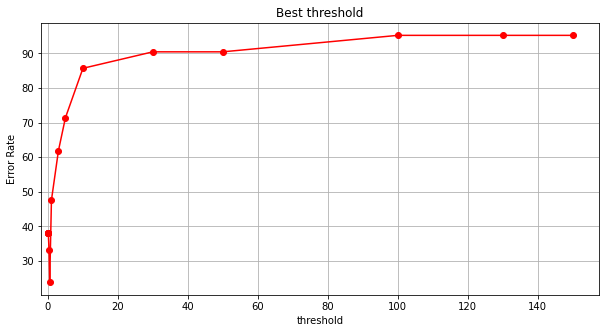

In [18]:
plt.figure(figsize=(10, 5))
plt.xlabel("threshold") 
plt.ylabel("Error Rate") 
x = thr_list.tolist()
y = Error_list
plt.plot(x, y, 'r-o') 
plt.title('Best threshold')
plt.xlim(-2,)
plt.grid()
plt.show()

# C. Changing the learning rate _ W=0, b=0, thr=1

In [19]:
W = np.zeros((63,7))                                             
b = np.zeros((1,7))
LR_list = np.array([0.01,0.02,0.1,0.3,0.5])
Error_list=[]
for i in LR_list:
    model = PerseptronModel(i,X_train,Y_train,1,W,b) 
    model.train(3000)  
    y_pred = model.predict(X_test)
    Error_list.append(model.ErrorRate(Y_test,np.array(y_pred))) 
print("Best learning rate: ",LR_list[Error_list.index(min(Error_list))],"Min Error on the test data: ",min(Error_list))

stopped at 13th epoch
stopped at 8th epoch
stopped at 6th epoch
stopped at 6th epoch
stopped at 6th epoch
Best learning rate:  0.3 Min Error on the test data:  33.33333333333333


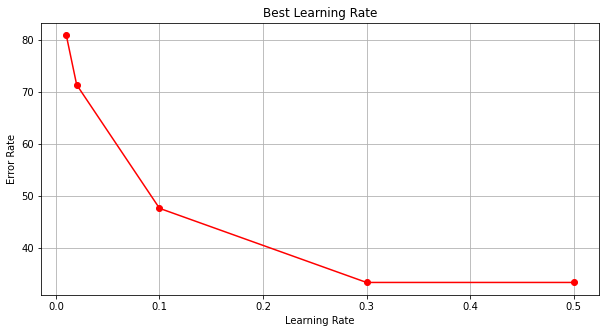

In [20]:
plt.figure(figsize=(10, 5))
plt.xlabel("Learning Rate") 
plt.ylabel("Error Rate") 
x = LR_list.tolist()
y = Error_list
plt.plot(x, y, 'r-o') 
plt.title('Best Learning Rate')
plt.grid()
plt.show()

# ADaline Model

In [21]:
class AdalineModel:
    def __init__(self,alpha,inputs,labels,threshold,w,bias):
        self.alpha = alpha
        self.inputs=np.append(inputs,np.ones((inputs.shape[0],1)),axis=1)
        self.labels = labels
        self.Y_pred = -np.ones_like(labels)
        self.w = np.append(w,bias,axis=0)      # random weights and bias
        self.thr = threshold

    def ActFunction(self,x,thr):
            for i in range(self.labels.shape[1]):
                if (-thr <= x[0][i]) & (x[0][i] <= thr):
                    x[0][i] = 0
                elif thr < x[0][i]:
                    x[0][i] = 1
                else: 
                    x[0][i] = -1
            return x  
        
    def forwardPath(self,row,x):
        y_in = np.dot(x[row].reshape(1,self.inputs.shape[1]),self.w) 
        self.Y_pred[row] = self.ActFunction(y_in,self.thr)
        return (y_in,self.w)
    
    def update(self,y,row):
        t = (self.labels[row]- y).reshape(1,self.labels.shape[1])
        self.w +=   self.alpha*np.dot(self.inputs[row].reshape(self.inputs.shape[1],1),t)
        
    def epoch(self):
        for i in range(self.inputs.shape[0]):
            pred = self.forwardPath(i,self.inputs)                # pred: tuple(y_in,w)  pred[0]: y_in
            result = self.update(pred[0],i)
           
        
    def train(self,epoc):                                             # '', iter: number of epocs
        for i in range(epoc):                                         
            self.epoch()                                             
                
                    
    def predict(self,x):
        predList = []
        for i in range(x.shape[0]):
            self.forwardPath(i,np.append(x,np.ones((21,1)),axis=1))
            
        return self.Y_pred
    
    def ErrorRate(self,y,predictedY):                           
       
        subtract = y-predictedY
        error = 0
        for i in subtract:
            if(not(np.array_equal(i,np.zeros_like(i)))):
                error +=1
        return 100 * (error/subtract.shape[0])

# Testing the model

In [283]:
W = np.random.uniform(low=-1, high=1, size=(63,7))
b = np.random.uniform(low=-1, high=1, size=(1,7))
Model =  AdalineModel(0.2,X_train,Y_train,1,W,b)              # alpha = 0.2
start_time = time.time()
Model.train(3000)                                       # 3000 epocs
print('durationt: ',time.time() - start_time)
print()
y_pred = Model.predict(X_test)
print('Error rate: ')
Model.ErrorRate(Y_test,np.array(y_pred))

durationt:  1.2068848609924316

Error rate: 


19.047619047619047

# Feature Extraction

In [6]:
def FeatureGenerator(Data):
    x = np.copy(Data)
    z = []
    for k in range(x.shape[0]):
        Lett = x[k].reshape(9,7)
        for i in range(Lett.shape[0]):
            c = collections.Counter(Lett[i])
            if 1 in list(c):
                if len(c) == 3:
                    z.append(c[list(c).index(1)])
                elif len(c) == 2:        
                    z.append(c[list(c).index(1)]) 
                else: 
                    z.append(c[list(c).index(1)]) 
            else:
                z.append(0)

        for j in range(Lett.shape[1]):
            c = collections.Counter(Lett[:,j])
            if 1 in list(c):
                if len(c) == 3:
                    z.append(c[list(c).index(1)])
                elif len(c) == 2:
                    z.append(c[list(c).index(1)]) 
                else: 
                    z.append(c[list(c).index(1)]) 
            else:
                z.append(0)
    z = np.array(z).reshape(21,16)
    return z

In [7]:
# Data = np.copy(X_train)
X_train2 = FeatureGenerator(X_train)

In [8]:
X_train2                              # 21 * 16

array([[2, 1, 1, 2, 2, 5, 2, 2, 0, 1, 4, 0, 0, 4, 4, 1],
       [1, 1, 1, 2, 2, 2, 5, 2, 2, 0, 4, 3, 0, 3, 4, 0],
       [1, 1, 2, 2, 2, 5, 0, 0, 0, 3, 3, 3, 0, 3, 3, 3],
       [0, 2, 2, 2, 5, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 6],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6],
       [0, 2, 2, 5, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 6],
       [5, 2, 1, 1, 1, 1, 1, 2, 4, 0, 7, 0, 0, 0, 0, 0],
       [3, 2, 0, 0, 0, 0, 0, 2, 3, 5, 2, 0, 0, 0, 2, 2],
       [4, 3, 0, 0, 0, 0, 0, 2, 3, 5, 2, 0, 0, 0, 2, 0],
       [0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 5],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 5],
       [0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 5],
       [0, 2, 1, 2, 3, 2, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 2, 2, 4, 2, 1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0],
       [4, 1, 1, 1, 1, 1, 2, 2, 3, 0, 2, 1, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 2, 2, 3, 0, 2, 1, 1, 1, 0, 0],
       [3, 1, 1, 1, 1, 1, 1, 2,

In [25]:
X_test2 = FeatureGenerator(X_test)
X_test2.shape

(21, 16)

In [32]:
W = np.random.uniform(low=-1, high=1, size=(16,7))
b = np.random.uniform(low=-1, high=1, size=(1,7))
Model =  AdalineModel(0.5,X_train2,Y_train,1,W,b) 
start_time = time.time()
Model.train(3000)                                      
print('durationt: ',time.time() - start_time)
print()
y_pred = Model.predict(X_train2)
print('Error rate: ')
Model.ErrorRate(Y_train,np.array(y_pred))

durationt:  1.071855068206787

Error rate: 


0.0

In [33]:
y_pred = Model.predict(X_test2)
print('Error rate: ')
Model.ErrorRate(Y_test,np.array(y_pred))

Error rate: 


57.14285714285714

# Checking for min Error on the test data

In [301]:
while(True):
    W = np.random.uniform(low=-1, high=1, size=(16,7))
    b = np.random.uniform(low=-1, high=1, size=(1,7))
    Model =  AdalineModel(0.5,X_train2,Y_train,1,W,b)              
    Model.train(5000)                                      
    y_pred = Model.predict(X_test2)
    e = Model.ErrorRate(Y_test,np.array(y_pred))
    if e < 55:
        print()
        print('Min Error Rate: ',e)
        print()
        print("Best weights:")
        print(W)
        print()
        print("Best bias:")
        print(b)
        break


Min Error Rate:  52.38095238095239

Best weights:
[[-0.58278996  0.13010722  0.5693514  -0.2228275   0.53975716  0.17084025
   0.98240043]
 [-0.75393055  0.83750526  0.00777062  0.96739964  0.83197855  0.15804312
   0.1875296 ]
 [-0.09751833 -0.88571161  0.31951642 -0.80407749 -0.54049137  0.85236998
  -0.68365138]
 [-0.90735126  0.68923566 -0.73676651 -0.72627142  0.68754876  0.09105671
   0.67693035]
 [-0.69271601 -0.14907671  0.78110703 -0.20944003 -0.17837626  0.08755321
  -0.56170006]
 [-0.35971205 -0.96235406 -0.78676832 -0.95413164 -0.43095073  0.84820963
  -0.68328201]
 [-0.19869682 -0.83716633  0.90617827 -0.12910196 -0.60596372 -0.62037172
   0.5085004 ]
 [-0.41869167  0.20252725  0.42776734  0.89128967 -0.3835003  -0.82522123
   0.99935129]
 [-0.61424561 -0.18434168  0.2846103  -0.4340614  -0.67047938 -0.67779138
   0.70623242]
 [ 0.04403452  0.87695953  0.13818494 -0.52797157 -0.49365183 -0.33702378
  -0.68802645]
 [-0.16063645 -0.75516577  0.28038189 -0.85870941  0.464601